In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import pandas as pd
import scanpy as sc

In [8]:
with open("data_for_model.csv", 'r') as file:
    df = pd.read_csv(file, index_col = 0)
    
healthy = sc.read_h5ad("GSE174188/GSE174188_Healthy.h5ad")

# Remove overall cells < 0.5% per person

In [9]:
sample = list(set(healthy.obs.ind_cov))

rows_to_remove = []
for i in sample:
    healthy = healthy[healthy.obs.Status == "Healthy", :]
    if healthy[healthy.obs.ind_cov == i,:].n_obs < healthy.n_obs*0.005:
        rows_to_remove.append(i)
    healthy_filter = healthy[~healthy.obs.ind_cov.isin(rows_to_remove),:]    
    
    
#移除overall <0.5%
healthy_filter

View of AnnData object with n_obs × n_vars = 474740 × 1999
    obs: 'batch_cov', 'ind_cov', 'Processing_Cohort', 'louvain', 'cg_cov', 'ct_cov', 'L3', 'ind_cov_batch_cov', 'Age', 'Sex', 'pop_cov', 'Status', 'SLE_status', 'cell_type'
    var: 'gene_ids'
    uns: 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [10]:
df = df.drop(columns = 'ID', axis = 1)

# Random Forest Regression

In [27]:
def RF_Regression(df, anndata_filter, cell_type):
    # 提取特定cell type的資料
    df_cell_type = df[df['cell_type'].str.contains(cell_type, case=False, na=False)]
    # 將cell type的那個欄位刪除
    df_cell_type = df_cell_type.drop(columns = 'cell_type', axis = 1)
    # 提取特定cell type的資料，目的是為了提取年齡
    anndata_cell_type = anndata_filter[anndata_filter.obs.cell_type == cell_type,:]
    
    age = []
    for i in anndata_cell_type.obs.Age:
        age.append(float(i))
        
    X = df_cell_type
    y = age
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)#, random_state=0)
    # n_jobs=-1處理器全開
    RFR = RandomForestRegressor(n_estimators=100, n_jobs=-1)# , random_state=0

    # 進行 k-fold cross-validation，例如 k=10
    scores = cross_val_score(RFR, X, y, cv=10)
    print('Cross-validation scores: ', scores)

    # train model
    RFR.fit(X_train, y_train)
    
    y_pred = RFR.predict(X_test)

    # 計算均方誤差（Mean Squared Error, MSE）
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error (MSE): {mse}')

    # 計算平均絕對誤差（Mean Absolute Error, MAE）
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Mean Absolute Error (MAE): {mae}')
    
    # 預測成功的比例
    print('Train Set score: ',RFR.score(X_train,y_train))
    print('Test Set score: ',RFR.score(X_test,y_test))

    # 計算皮爾森相關係數
    corr, _ = pearsonr(y_test, y_pred)
    print(f'Pearson correlation: {corr}')
    
    plt.scatter(y_test, y_pred, s=10, label='True')
    plt.xlabel('Actual Ages')
    plt.ylabel('Predicted Ages')
    plt.title('Actual vs Predicted Ages')
    plt.show()

## NK

Cross-validation scores:  [0.99897645 0.99952433 0.99560716 0.99861542 0.99669198 0.99947096
 0.99710381 0.99512674 0.99754608 0.99781194]
Mean Squared Error (MSE): 0.5919439720129172
Mean Absolute Error (MAE): 0.07969680660208112
訓練集:  0.9994397879561544
測試集:  0.9965804223109463
Pearson correlation: 0.998290705752276


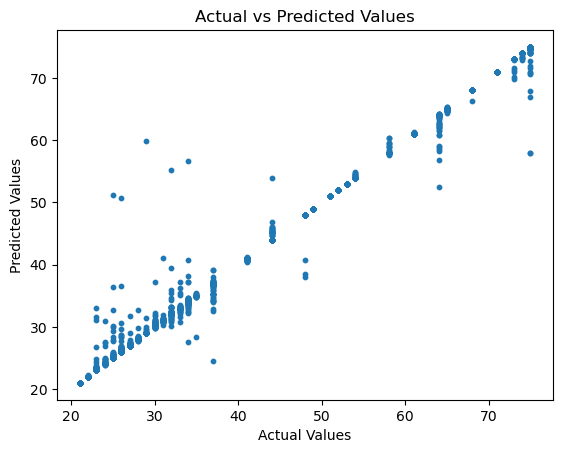

In [20]:
RF_Regression(df, healthy_filter, "NK")

## CD4 T

Cross-validation scores:  [0.99877521 0.99948756 0.9998532  0.99935701 0.99930789 0.99934283
 0.99957903 0.99967719 0.99965562 0.99959243]
Mean Squared Error (MSE): 0.1845010664448757
Mean Absolute Error (MAE): 0.02330875150170963
訓練集:  0.9998527971124763
測試集:  0.9988193513751268
Pearson correlation: 0.999410049312017


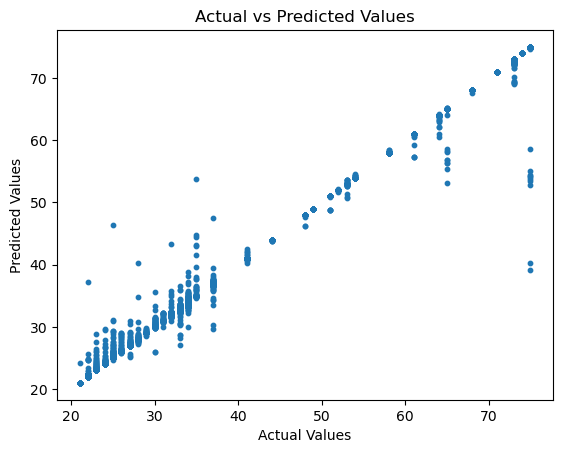

In [21]:
RF_Regression(df, healthy_filter, "CD4 T")

## CD8 T

Cross-validation scores:  [0.99791056 0.99916998 0.99890588 0.99965409 0.99852473 0.99942605
 0.99978542 0.99906963 0.99926688 0.99906172]
Mean Squared Error (MSE): 0.29381804080061585
Mean Absolute Error (MAE): 0.02683718244803694
訓練集:  0.999906036262805
測試集:  0.9978218502963435
Pearson correlation: 0.9989108499462698


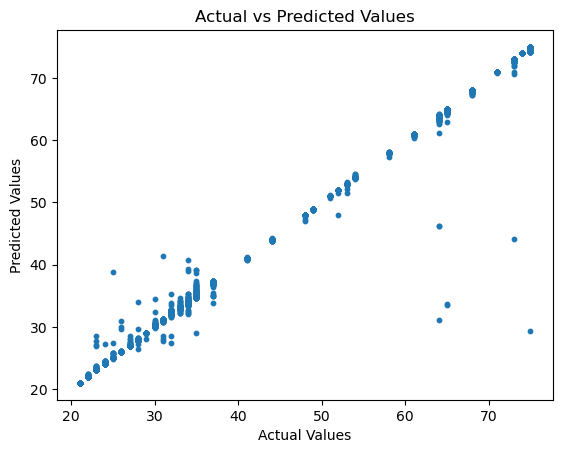

In [23]:
RF_Regression(df, healthy_filter, "CD8 T")

## B

Cross-validation scores:  [0.99957353 0.99850703 0.99900859 0.9997117  0.99543277 0.99811605
 0.99956422 0.99914757 0.99947212 0.99942807]
Mean Squared Error (MSE): 0.2600744469089462
Mean Absolute Error (MAE): 0.02925666837286018
訓練集:  0.9998733334939923
測試集:  0.9985121056735103
Pearson correlation: 0.9992557836356627


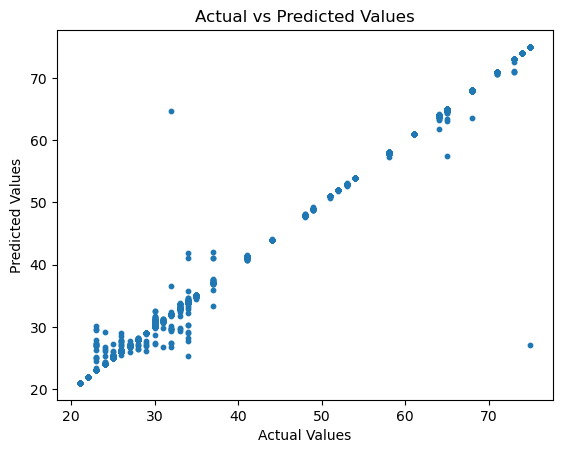

In [24]:
RF_Regression(df, healthy_filter, "B")

## Monocyte

Cross-validation scores:  [0.99940837 0.99835434 0.99921848 0.99731322 0.99967169 0.999338
 0.99960979 0.99839881 0.99870807 0.99863634]
Mean Squared Error (MSE): 0.14881819924015732
Mean Absolute Error (MAE): 0.041205998049961355
訓練集:  0.9997919037449953
測試集:  0.9991171905685283
Pearson correlation: 0.9995595254374912


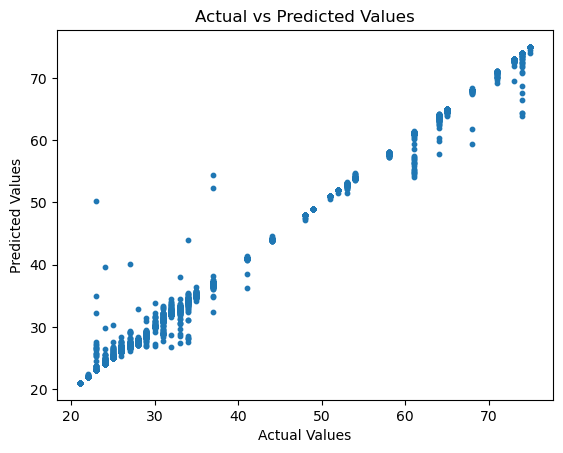

In [25]:
RF_Regression(df, healthy_filter, "Monocyte")

## DC

Cross-validation scores:  [0.95572684 0.97782333 0.94664161 0.94503481 0.94052816 0.93403313
 0.95394664 0.93619482 0.94856218 0.97032001]
Mean Squared Error (MSE): 10.518288516590761
Mean Absolute Error (MAE): 1.0605432661027976
訓練集:  0.98841878886879
測試集:  0.9260826299690458
Pearson correlation: 0.96438597331271


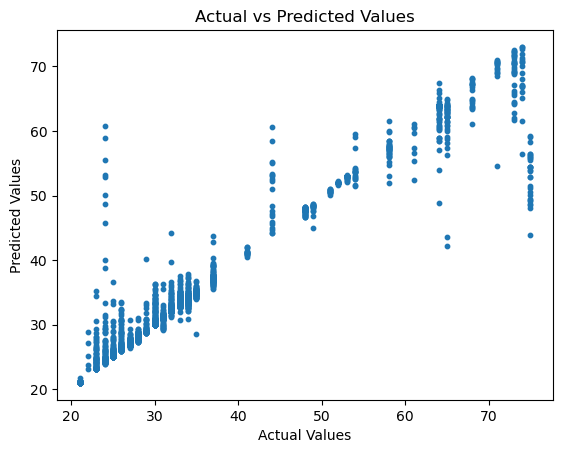

In [26]:
RF_Regression(df, healthy_filter, "DC")